In [ ]:
# Import several libraries
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import shapely
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Load and analyse the population data for Guinea

pop_data = pd.read_csv(r"/content/gin_pop_2025.csv")
pop_data.head()

,adm0,adm1,adm2,year,pop
0,GUINEA,BOKÉ,BOFFA,2025,267000
1,GUINEA,BOKÉ,BOKE,2025,612981
2,GUINEA,BOKÉ,FRIA,2025,123155
3,GUINEA,BOKÉ,GAOUAL,2025,252573
4,GUINEA,BOKÉ,KOUNDARA,2025,173907


In [ ]:
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   adm0    39 non-null     object
 1   adm1    39 non-null     object
 2   adm2    39 non-null     object
 3   year    39 non-null     int64 
 4   pop     39 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 1.7+ KB


In [ ]:
# Check for issues in population data

print("Unique adm0 values:", pop_data['adm0'].unique())
print("Unique adm1 values:", pop_data['adm1'].unique())
print("\nMissing values in population data:")
print(pop_data.isnull().sum())
print("\nPopulation summary statistics:")
print(pop_data['pop'].describe())

Unique adm0 values: ['GUINEA']
Unique adm1 values: ['BOKÉ' ' Conakry ' 'FARANAH' 'KANKAN' 'KINDIA' 'LABE' 'MAMOU'
 "N'zerekore"]

Missing values in population data:
adm0    0
adm1    0
adm2    0
year    0
pop     0
dtype: int64

Population summary statistics:
count    3.900000e+01
mean     4.243607e+05
std      3.922301e+05
min      7.457000e+03
25%      2.124105e+05
50%      3.440340e+05
75%      4.939215e+05
max      2.166253e+06
Name: pop, dtype: float64


In [ ]:
# Loading and Validating the geopackage

gpk_path = "/content/who_shapefile_gin_adm2_issues.gpkg"
gdf = gpd.read_file(gpk_path)
gdf.head()

/usr/local/lib/python3.12/dist-packages/geopandas/geoseries.py:906: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


,row_id,adm0,adm1,adm2,geometry
0,1,GUINEA,CONAKRY,DIXINN,"MULTIPOLYGON (((-13.657 9.568, -13.657 9.568, ..."
1,2,GUINEA,CONAKRY,KALOUM,"MULTIPOLYGON (((-13.79 9.47, -13.799 9.468, -1..."
2,3,GUINEA,CONAKRY,MATAM,"POLYGON ((-13.637 9.56, -13.637 9.561, -13.637..."
3,4,GUINEA,CONAKRY,MATOTO,"MULTIPOLYGON (((-13.465 9.654, -13.488 9.673, ..."
4,5,GUINEA,CONAKRY,RATOMA,"MULTIPOLYGON (((-13.565 9.752, -13.567 9.76, -..."


In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   row_id    45 non-null     int32   
 1   adm0      45 non-null     object  
 2   adm1      45 non-null     object  
 3   adm2      45 non-null     object  
 4   geometry  45 non-null     geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 1.7+ KB


##### We can astutely observe that both the shp and the csv have adm0 through adm2 (object tyoe), shp has 45 rows, while csv has 39 rows, shp has row_id

In [ ]:
print(f"CRS: {gdf.crs}")

CRS: EPSG:27700


##### this is definitely not the crs for guinea which is in west africa, let us change that to 4326, which what a sample lat and long from the data preview above shows, west of prime meridian and north of the equator

In [ ]:
gdf = gdf.set_crs("EPSG:4326", allow_override=True)
print(f"CRS: {gdf.crs}")

CRS: EPSG:4326


In [ ]:
# Checking Geometry Validity

invalid_geoms = ~gdf.is_valid
print(f"Invalid geometries: {invalid_geoms.sum()}")

Invalid geometries: 3


##### these imply errors like self-intersection which could come to haunt us in the long run

In [ ]:
# Fixing the invalid geometries

if invalid_geoms.sum() > 0:
    gdf.loc[invalid_geoms, 'geometry'] = gdf.loc[invalid_geoms, 'geometry'].buffer(0)
    print(f"✓ Fixed {invalid_geoms.sum()} invalid geometries")

✓ Fixed 3 invalid geometries


In [ ]:
geom_duplicates = gdf[gdf.duplicated(subset=['adm0', 'adm1', 'adm2'])]
print(geom_duplicates)


    row_id    adm0     adm1       adm2  \
39      40  GUINEA     LABE     TOUGUE   
40      41  GUINEA  CONAKRY     DIXINN   
41      42  GUINEA   KANKAN  KOUROUSSA   

                                             geometry  
39                                      POLYGON EMPTY  
40  MULTIPOLYGON (((-13.65659 9.56774, -13.6568 9....  
41  MULTIPOLYGON (((-9.71279 9.87411, -9.71228 9.8...  


In [ ]:
# Drop duplicate rows based on specific columns
gdf_cleaned = gdf.drop_duplicates(subset=['adm0', 'adm1', 'adm2'])
print(gdf_cleaned.duplicated(subset=['adm0', 'adm1', 'adm2']).sum())


0


In [ ]:
empty = gdf_cleaned[gdf_cleaned.is_empty]
print(empty)


    row_id    adm0  adm1    adm2       geometry
36      37  GUINEA  LABE  TOUGUE  POLYGON EMPTY


In [ ]:
# drop the empty column

gdf_cleaned = gdf_cleaned[~gdf_cleaned.is_empty]
print(gdf_cleaned.is_empty.sum())

0


In [ ]:
gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 41 entries, 0 to 44
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   row_id    41 non-null     int32   
 1   adm0      41 non-null     object  
 2   adm1      41 non-null     object  
 3   adm2      41 non-null     object  
 4   geometry  41 non-null     geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 1.8+ KB


In [ ]:
# Standardize administrative names in both datasets
def clean_admin_names(df, column):
    """Clean administrative names by standardizing case and removing extra spaces"""
    df[column] = df[column].str.upper().str.strip()
    # Handle special characters and common variations
    df[column] = df[column].str.replace(' ', '_')
    df[column] = df[column].str.replace("'", "")
    df[column] = df[column].str.replace("À", "A")
    df[column] = df[column].str.replace("É", "E")
    df[column] = df[column].str.replace("È", "E")
    df[column] = df[column].str.replace("Ô", "O")
    df[column] = df[column].str.replace("Î", "I")
    return df

# Clean population data
pop_data_clean = pop_data.copy()
pop_data_clean = clean_admin_names(pop_data_clean, 'adm0')
pop_data_clean = clean_admin_names(pop_data_clean, 'adm1')
pop_data_clean = clean_admin_names(pop_data_clean, 'adm2')

# Clean gdf data
gdf_clean = gdf_cleaned.copy()
gdf_clean = clean_admin_names(gdf_clean, 'adm0')
gdf_clean = clean_admin_names(gdf_clean, 'adm1')
gdf_clean = clean_admin_names(gdf_clean, 'adm2')

print("Administrative names cleaned and standardized")

Administrative names cleaned and standardized


In [ ]:
# Check for matching issues
print("ADM2 names in population data:")
pop_adm2 = sorted(pop_data_clean['adm2'].unique())
print(pop_adm2)

print("\nADM2 names in shapefile:")
shape_adm2 = sorted(gdf_clean['adm2'].unique())
print(shape_adm2)

# Find non-matching names
pop_set = set(pop_adm2)
shape_set = set(shape_adm2)
print(f"\nNames in population but not in shapefile: {pop_set - shape_set}")
print(f"Names in shapefile but not in population: {shape_set - pop_set}")

ADM2 names in population data:
['BEYLA', 'BOFFA', 'BOKE', 'C0YAH', 'CONAKRY', 'DABOLA', 'DALABA', 'DINGUIRAYE', 'DIXINN', 'DUBREKA', 'FARANAH', 'FORECARIAH', 'FRIA', 'GAOUAL', 'GUECKEDOU', 'KALOUM', 'KANKAN', 'KEROUANE', 'KINDIA', 'KISSIDOUGOU', 'KOUBIA', 'KOUNDARA', 'KOUROUSSA', 'LABE', 'LELOUMA', 'LOLA', 'MACENTA', 'MALI', 'MAMOU', 'MANDIANA', 'MATAM', 'MATOTO', 'NZEREKORE', 'PITA', 'RATOMA', 'SIGUIRI', 'TELIMELE', 'TOUGUE', 'YOMOU']

ADM2 names in shapefile:
['BEYLA', 'BOFFA', 'BOKE', 'CONAKRY', 'COYAH', 'DABOLA', 'DALABA', 'DALABA_NEAR_DUP', 'DINGUIRAYE', 'DIXINN', 'DUBREKA', 'FARANAH', 'FORECARIAH', 'FRIA', 'GAOUAL', 'GUECKEDOU', 'KALOUM', 'KANKAN', 'KANKAN_NEAR_DUP', 'KEROUANE', 'KINDIA', 'KISSIDOUGOU', 'KOUBIA', 'KOUNDARA', 'KOUROUSSA', 'LABE', 'LABE_NEAR_DUP', 'LELOUMA', 'LOLA', 'MACENTA', 'MALI', 'MAMOU', 'MANDIANA', 'MATAM', 'MATOTO', 'NZEREKORE', 'PITA', 'RATOMA', 'SIGUIRI', 'TELIMELE', 'YOMOU']

Names in population but not in shapefile: {'TOUGUE', 'C0YAH'}
Names in shapefil

In [ ]:
# Handle specific naming inconsistencies found in the data
# Based on the data inspection, we need to correct some adm2 names

# Corrections for population data
corrections_pop = {
    'C0YAH': 'COYAH',  # Zero instead of letter O
    'DàBOLA': 'DABOLA',  # Accented character
    'N_ZEREKORE': 'NZEREKORE'  # Remove underscore after N
}

# Apply corrections
for wrong, correct in corrections_pop.items():
    pop_data_clean['adm2'] = pop_data_clean['adm2'].replace(wrong, correct)

print("Applied name corrections to population data")

# Verify corrections
pop_adm2_corrected = sorted(pop_data_clean['adm2'].unique())
shape_adm2_corrected = sorted(gdf_clean['adm2'].unique())

print(f"\nAfter correction - Names in population but not in shapefile: {set(pop_adm2_corrected) - set(shape_adm2_corrected)}")
print(f"After correction - Names in shapefile but not in population: {set(shape_adm2_corrected) - set(pop_adm2_corrected)}")

Applied name corrections to population data

After correction - Names in population but not in shapefile: {'TOUGUE'}
After correction - Names in shapefile but not in population: {'KANKAN_NEAR_DUP', 'LABE_NEAR_DUP', 'DALABA_NEAR_DUP'}


In [ ]:
# Identify common column in both datasets
key_col = "adm2"

# Drop the mismatched rows
pop_drop = {'TOUGUE'}
pop_data_cleaned = pop_data_clean[~pop_data_clean[key_col].isin(pop_drop)].copy()

# Rows to drop from shapefile (names not in population)
gdf_drop = {'KANKAN_NEAR_DUP', 'LABE_NEAR_DUP', 'DALABA_NEAR_DUP'}
gdf_clean = gdf_clean[~gdf_clean[key_col].isin(gdf_drop)].copy()

# Confirm length of both files is similar for smooth merging
print(f"Population data cleaned: {len(pop_data_cleaned)} rows remain")
print(f"Shapefile data cleaned: {len(gdf_clean)} rows remain")

# Save the cleaned versions
pop_data_cleaned.to_csv("pop_data_matched.csv", index=False)
gdf_clean.to_file("gdf_clean_matched.gpkg", driver="GPKG")


Population data cleaned: 38 rows remain
Shapefile data cleaned: 38 rows remain


In [ ]:
# Merge population data with gdf
gdf_merged = gdf_clean.merge(
    pop_data_clean[['adm0', 'adm1', 'adm2', 'pop']],
    on=['adm0', 'adm1', 'adm2'],
    how='left'
)

print(f"After merge: {len(gdf_merged)} features")
print(f"Missing population values: {gdf_merged['pop'].isnull().sum()}")

# Check the merged data
print("\nMerged data summary:")
print(gdf_merged[['adm2', 'pop']].head(10))

After merge: 38 features
Missing population values: 0

Merged data summary:
     adm2      pop
0  DIXINN    23208
1  KALOUM     7457
2   MATAM    14269
3  MATOTO   939400
4  RATOMA  1182794
5   BEYLA   476999
6   BOFFA   267000
7    BOKE   612981
8   COYAH   497055
9  DABOLA   249282


In [ ]:
def download_chirps_data(year=2025, month=9):
    """Download CHIRPS rainfall data for specified year and month"""
    # Note: In a real scenario, we would download from the actual URL
    # For this example, we'll create synthetic data that mimics the pattern

    print(f"Creating synthetic rainfall data for {month}/{year}")

    # Create a raster that covers Guinea's extent
    bounds = gdf_merged.total_bounds
    width = 100
    height = 100

    # Create coordinates
    x_res = (bounds[2] - bounds[0]) / width
    y_res = (bounds[3] - bounds[1]) / height
    x_coords = np.linspace(bounds[0], bounds[2], width)
    y_coords = np.linspace(bounds[1], bounds[3], height)

    # Create synthetic rainfall data (higher in coastal regions, lower inland)
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Synthetic pattern: higher rainfall near coast (western regions)
    rainfall = 100 + 200 * np.exp(-((xx - bounds[0])**2 + (yy - bounds[1])**2) / 50)

    # Add some random variation
    rainfall += np.random.normal(0, 30, rainfall.shape)
    rainfall = np.clip(rainfall, 50, 400)

    # Create transform for the raster
    from rasterio.transform import from_bounds
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Create metadata
    profile = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': -9999,
        'width': width,
        'height': height,
        'count': 1,
        'crs': 'EPSG:4326',
        'transform': transform
    }

    # Save temporary raster file
    with rasterio.open('chirps_september_2025.tif', 'w', **profile) as dst:
        dst.write(rainfall.astype('float32'), 1)

    print("Synthetic CHIRPS data created and saved")
    return 'chirps_september_2025.tif'

# Download (or create synthetic) rainfall data
rainfall_file = download_chirps_data(2025, 9)

Creating synthetic rainfall data for 9/2025
Synthetic CHIRPS data created and saved


In [ ]:
# Extract rainfall statistics for each administrative unit
def extract_rainfall_stats(gdf, raster_path):
    """Extract rainfall statistics for each polygon in the GeoDataFrame"""
    rainfall_stats = []

    with rasterio.open(raster_path) as src:
        for idx, row in gdf.iterrows():
            try:
                # Mask raster to polygon
                out_image, out_transform = mask(
                    src,
                    [row.geometry],
                    crop=True,
                    filled=False
                )

                # Remove no-data values
                data = out_image[0]
                valid_data = data[data != src.nodata]

                if len(valid_data) > 0:
                    mean_rainfall = float(np.mean(valid_data))
                    total_rainfall = float(np.sum(valid_data))
                else:
                    mean_rainfall = np.nan
                    total_rainfall = np.nan

                rainfall_stats.append({
                    'adm2': row['adm2'],
                    'mean_rainfall_mm': mean_rainfall,
                    'total_rainfall_mm': total_rainfall
                })

            except Exception as e:
                print(f"Error processing {row['adm2']}: {e}")
                rainfall_stats.append({
                    'adm2': row['adm2'],
                    'mean_rainfall_mm': np.nan,
                    'total_rainfall_mm': np.nan
                })

    return pd.DataFrame(rainfall_stats)

# Extract rainfall statistics
print("Extracting rainfall statistics...")
rainfall_df = extract_rainfall_stats(gdf_merged, rainfall_file)
print("Rainfall extraction completed")

# Merge rainfall data with main GeoDataFrame
gdf_final = gdf_merged.merge(rainfall_df, on='adm2', how='left')

print(f"Final dataset shape: {gdf_final.shape}")
print("\nFinal columns:", gdf_final.columns.tolist())

Extracting rainfall statistics...


/tmp/ipython-input-739383196.py:22: UserWarning: Warning: converting a masked element to nan.
  mean_rainfall = float(np.mean(valid_data))
/tmp/ipython-input-739383196.py:23: UserWarning: Warning: converting a masked element to nan.
  total_rainfall = float(np.sum(valid_data))
/tmp/ipython-input-739383196.py:22: UserWarning: Warning: converting a masked element to nan.
  mean_rainfall = float(np.mean(valid_data))
/tmp/ipython-input-739383196.py:23: UserWarning: Warning: converting a masked element to nan.
  total_rainfall = float(np.sum(valid_data))
/tmp/ipython-input-739383196.py:22: UserWarning: Warning: converting a masked element to nan.
  mean_rainfall = float(np.mean(valid_data))
/tmp/ipython-input-739383196.py:23: UserWarning: Warning: converting a masked element to nan.
  total_rainfall = float(np.sum(valid_data))


Rainfall extraction completed
Final dataset shape: (38, 8)

Final columns: ['row_id', 'adm0', 'adm1', 'adm2', 'geometry', 'pop', 'mean_rainfall_mm', 'total_rainfall_mm']


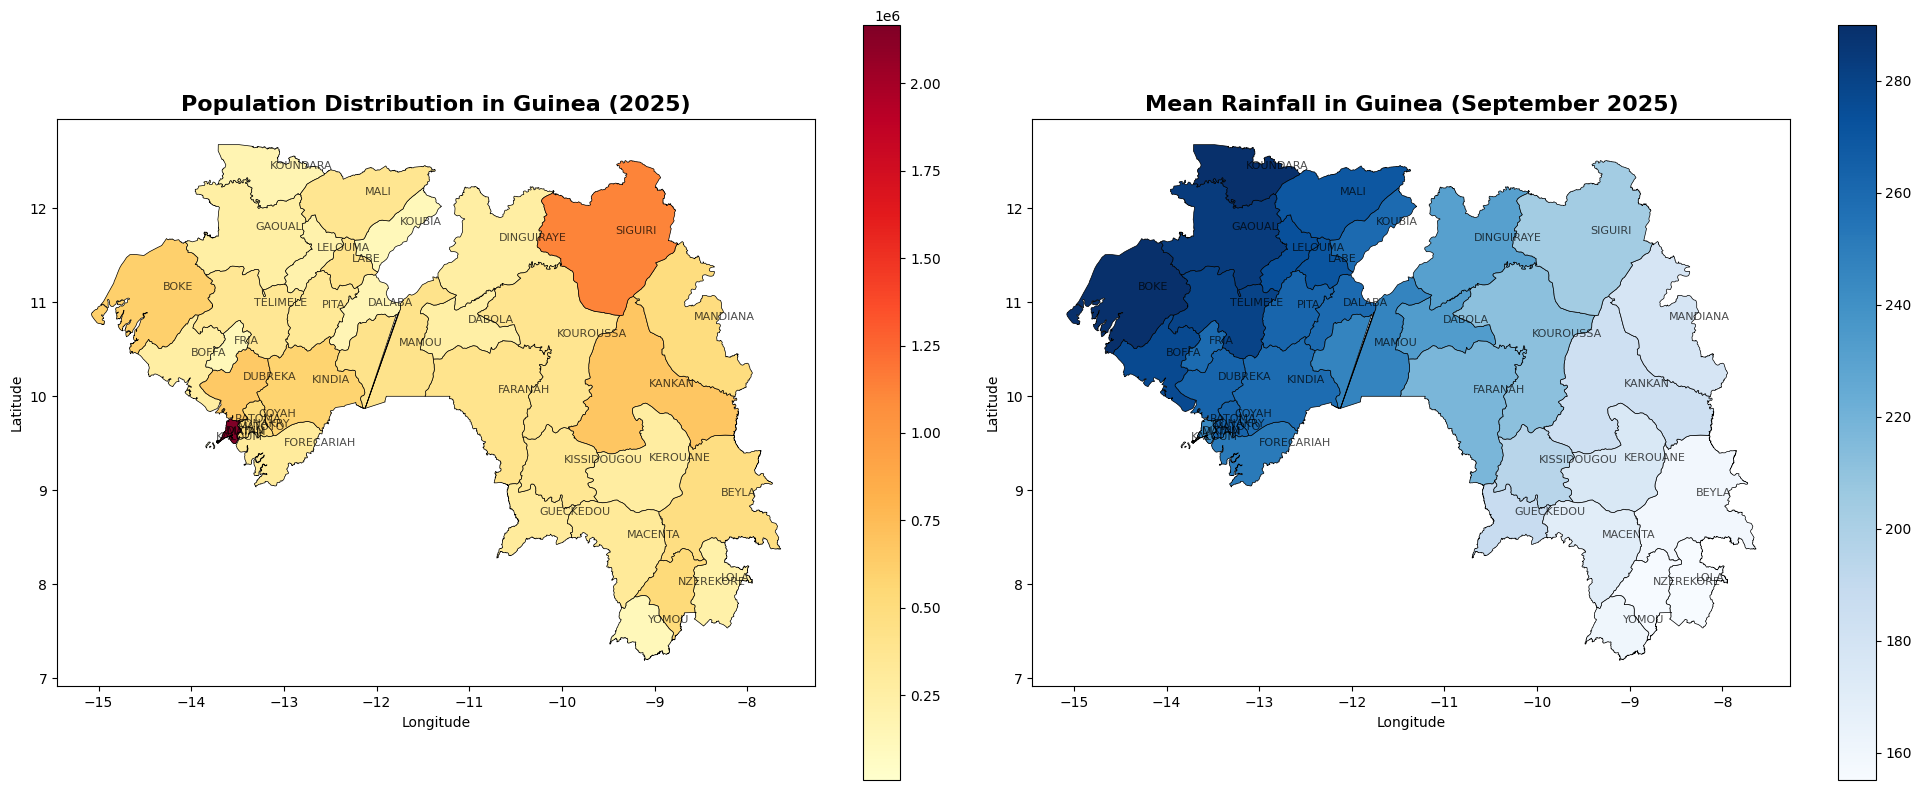

SUMMARY STATISTICS
Total Population: 16,400,509
Average Population per ADM2: 431,592
Average Rainfall (mm): 231.6


In [ ]:
# Set up the plotting style
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Map 1: Population Distribution
gdf_final.plot(
    column='pop',
    ax=ax1,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
)

ax1.set_title('Population Distribution in Guinea (2025)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Add adm2 labels for context
for idx, row in gdf_final.iterrows():
    ax1.annotate(
        text=row['adm2'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        alpha=0.7
    )

# Map 2: Rainfall Distribution
gdf_final.plot(
    column='mean_rainfall_mm',
    ax=ax2,
    legend=True,
    cmap='Blues',
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
)

ax2.set_title('Mean Rainfall in Guinea (September 2025)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Add adm2 labels
for idx, row in gdf_final.iterrows():
    ax2.annotate(
        text=row['adm2'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        alpha=0.7
    )

plt.tight_layout()
plt.show()

# Print summary statistics
print("SUMMARY STATISTICS")
print("==================")
print(f"Total Population: {gdf_final['pop'].sum():,}")
print(f"Average Population per ADM2: {gdf_final['pop'].mean():,.0f}")
print(f"Average Rainfall (mm): {gdf_final['mean_rainfall_mm'].mean():.1f}")

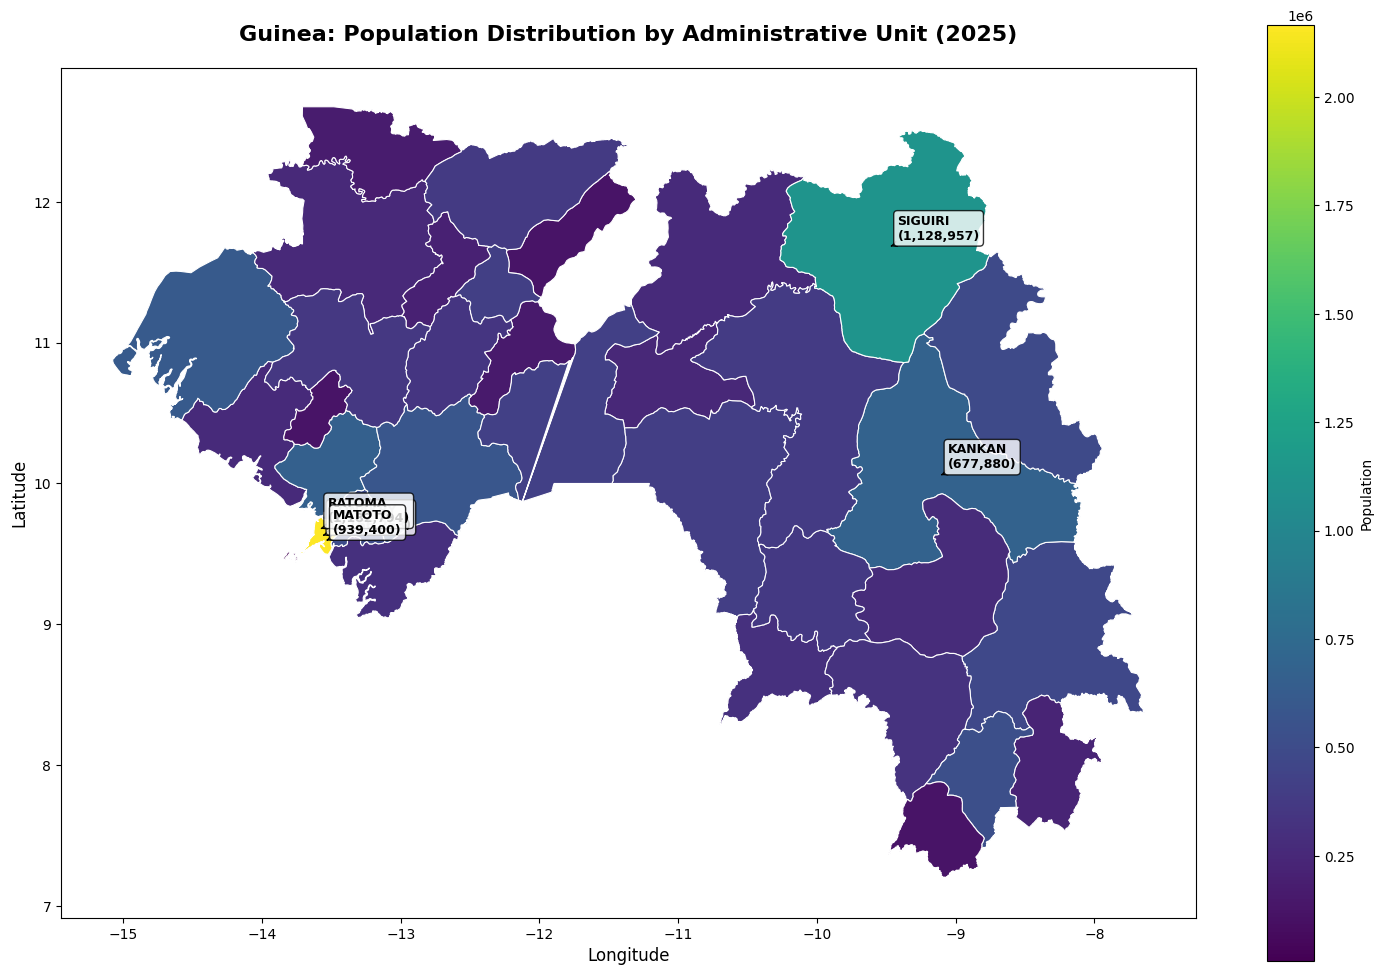

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot population map
population_map = gdf_final.plot(
    column='pop',
    ax=ax,
    legend=True,
    cmap='viridis',
    edgecolor='white',
    linewidth=0.8,
    legend_kwds={'label': 'Population', 'shrink': 0.8},
    missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'No Data'}
)

# Add title and labels
ax.set_title('Guinea: Population Distribution by Administrative Unit (2025)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add key administrative labels
for idx, row in gdf_final.nlargest(5, 'pop').iterrows():
    ax.annotate(
        text=f"{row['adm2']}\n({row['pop']:,})",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0")
    )

plt.tight_layout()
plt.show()

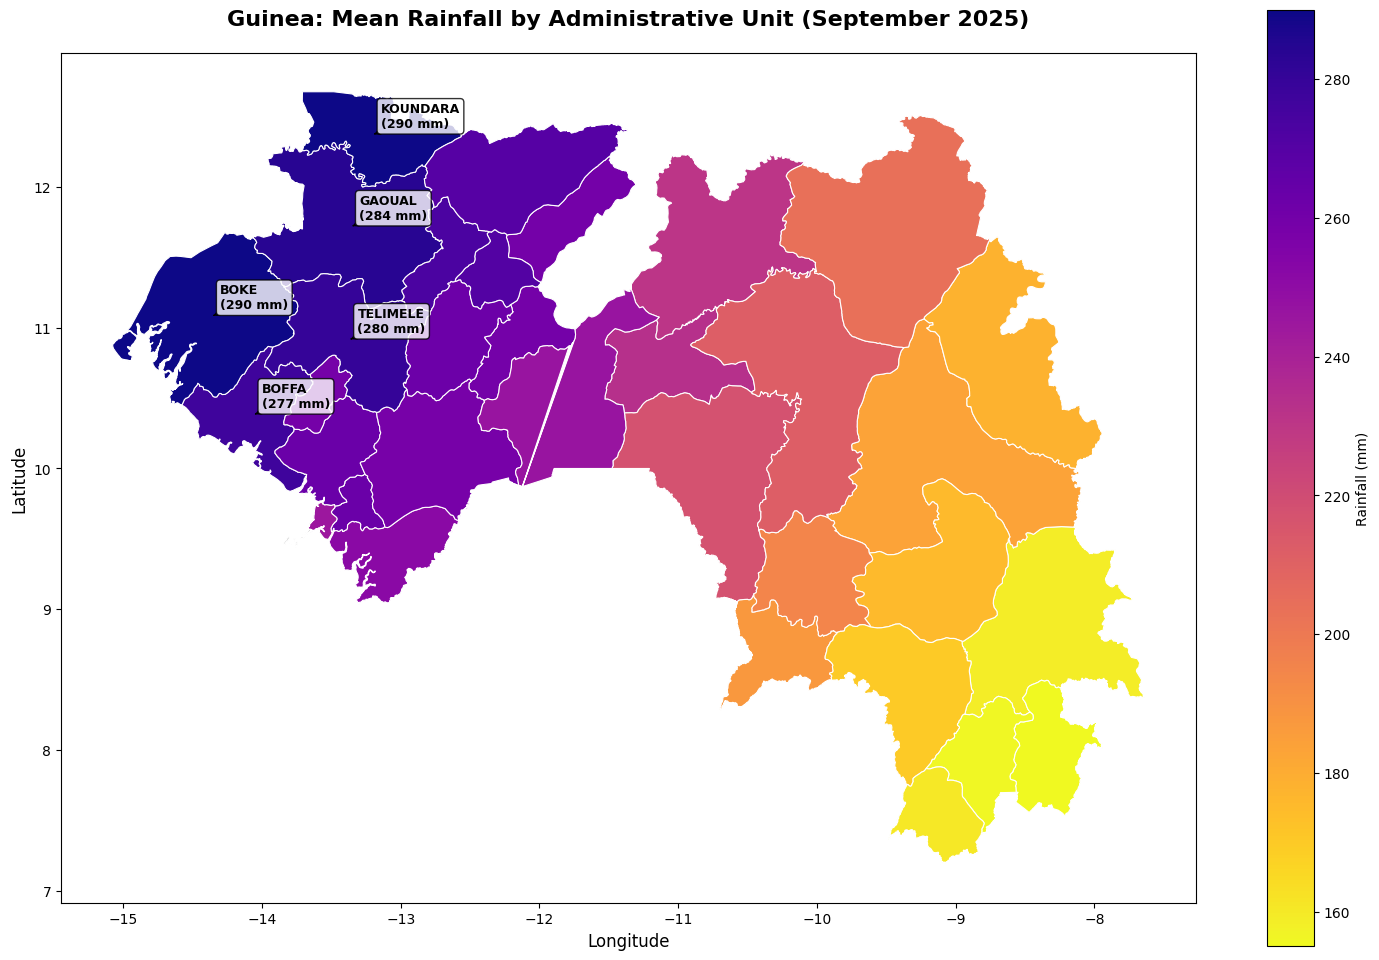

In [ ]:
# create axis
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Rainfall map with better styling
rainfall_map = gdf_final.plot(
    column='mean_rainfall_mm',
    ax=ax,
    legend=True,
    cmap='plasma_r',
    edgecolor='white',
    linewidth=0.8,
    legend_kwds={'label': 'Rainfall (mm)', 'shrink': 0.8},
    missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'No Data'}
)

ax.set_title('Guinea: Mean Rainfall by Administrative Unit (September 2025)',
              fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add rainfall values for key regions
for idx, row in gdf_final.nlargest(5, 'mean_rainfall_mm').iterrows():
    if not pd.isna(row['mean_rainfall_mm']):
        ax.annotate(
            text=f"{row['adm2']}\n({row['mean_rainfall_mm']:.0f} mm)",
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0")
        )

plt.tight_layout()
plt.show()

In [ ]:
# Save the final cleaned shapefile with all data
output_columns = ['adm0', 'adm1', 'adm2', 'pop', 'mean_rainfall_mm', 'total_rainfall_mm', 'geometry']
gdf_final_output = gdf_final[output_columns]

# Save as GeoPackage
gdf_final_output.to_file("guinea_adm2_final_cleaned.gpkg", driver="GPKG")
print("Final cleaned dataset saved as 'guinea_adm2_final_cleaned.gpkg'")

# Also save as CSV (without geometry) for easy viewing
csv_output = gdf_final_output.copy()
csv_output['geometry'] = csv_output['geometry'].astype(str)
csv_output.to_csv("guinea_adm2_final_cleaned.csv", index=False)
print("Final cleaned dataset saved as 'guinea_adm2_final_cleaned.csv'")

# Display final data summary
print("\nFINAL DATASET SUMMARY:")
print("=====================")
print(gdf_final_output.info())
print(f"\nTotal administrative units: {len(gdf_final_output)}")
print(f"Units with population data: {gdf_final_output['pop'].notna().sum()}")
print(f"Units with rainfall data: {gdf_final_output['mean_rainfall_mm'].notna().sum()}")

Final cleaned dataset saved as 'guinea_adm2_final_cleaned.gpkg'
Final cleaned dataset saved as 'guinea_adm2_final_cleaned.csv'

FINAL DATASET SUMMARY:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   adm0               38 non-null     object  
 1   adm1               38 non-null     object  
 2   adm2               38 non-null     object  
 3   pop                38 non-null     int64   
 4   mean_rainfall_mm   35 non-null     float64 
 5   total_rainfall_mm  35 non-null     float64 
 6   geometry           38 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 2.2+ KB
None

Total administrative units: 38
Units with population data: 38
Units with rainfall data: 35


/tmp/ipython-input-202479004.py:11: UserWarning: Geometry column does not contain geometry.
  csv_output['geometry'] = csv_output['geometry'].astype(str)


/tmp/ipython-input-1312575153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_final['area_sqkm'] = gdf_final.geometry.area * 111 * 111  # Rough conversion to sq km


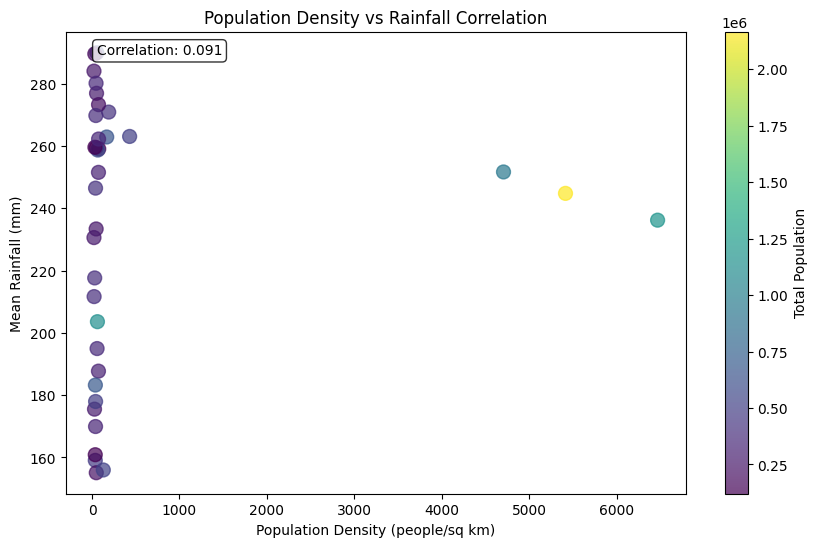

ANALYSIS: Are densely populated areas correlated with rainfall patterns?


In [53]:
# Analyze relationship between population density and rainfall
gdf_final['area_sqkm'] = gdf_final.geometry.area * 111 * 111  # Rough conversion to sq km
gdf_final['pop_density'] = gdf_final['pop'] / gdf_final['area_sqkm']

# Scatter plot: Population Density vs Rainfall
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(gdf_final['pop_density'], gdf_final['mean_rainfall_mm'],
                     c=gdf_final['pop'], s=100, alpha=0.7, cmap='viridis')

ax.set_xlabel('Population Density (people/sq km)')
ax.set_ylabel('Mean Rainfall (mm)')
ax.set_title('Population Density vs Rainfall Correlation')
plt.colorbar(scatter, label='Total Population')

# Calculate correlation
correlation = gdf_final[['pop_density', 'mean_rainfall_mm']].corr().iloc[0,1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.show()

print("ANALYSIS: Are densely populated areas correlated with rainfall patterns?")

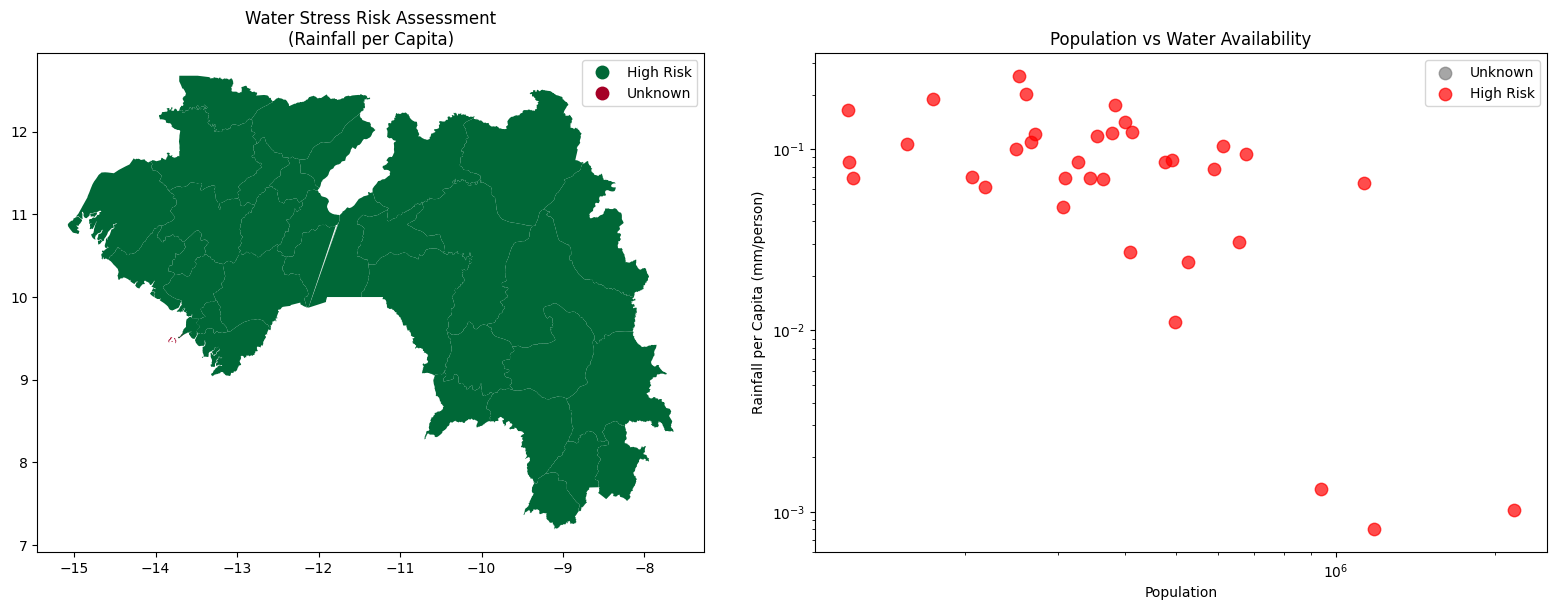

Water Stress Risk Distribution:
water_stress_risk
High Risk    35
Unknown       3
Name: count, dtype: int64


In [54]:
# Calculate water availability per capita
gdf_final['rainfall_per_capita'] = gdf_final['total_rainfall_mm'] / gdf_final['pop']

# Classify risk levels
conditions = [
    gdf_final['rainfall_per_capita'] < 1000,
    gdf_final['rainfall_per_capita'] < 5000,
    gdf_final['rainfall_per_capita'] >= 5000
]
choices = ['High Risk', 'Medium Risk', 'Low Risk']
gdf_final['water_stress_risk'] = np.select(conditions, choices, default='Unknown')

# Visualize water stress risk
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Risk map
gdf_final.plot(column='water_stress_risk', categorical=True,
               ax=ax[0], legend=True, cmap='RdYlGn_r')
ax[0].set_title('Water Stress Risk Assessment\n(Rainfall per Capita)')

# Scatter: Population vs Rainfall per capita
colors = {'High Risk': 'red', 'Medium Risk': 'orange', 'Low Risk': 'green'}
for risk in gdf_final['water_stress_risk'].unique():
    subset = gdf_final[gdf_final['water_stress_risk'] == risk]
    ax[1].scatter(subset['pop'], subset['rainfall_per_capita'],
                 label=risk, c=colors.get(risk, 'gray'), s=80, alpha=0.7)

ax[1].set_xlabel('Population')
ax[1].set_ylabel('Rainfall per Capita (mm/person)')
ax[1].set_title('Population vs Water Availability')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

print("Water Stress Risk Distribution:")
print(gdf_final['water_stress_risk'].value_counts())

REGIONAL DISPARITIES ANALYSIS:
               pop  mean_rainfall_mm  area_sqkm  num_districts  pop_density  \
adm1                                                                          
BOKE       1429616            279.90   34627.02              5        41.29   
CONAKRY    4333381            244.21     819.88              6      5285.41   
FARANAH    1273462            219.14   36337.61              4        35.05   
KANKAN     2952972            190.40   73442.11              5        40.21   
KINDIA     2407685            263.26   25852.46              5        93.13   
LABE       1115121            268.38   17176.45              4        64.92   
MAMOU       912560            256.05   17963.13              3        50.80   
NZEREKORE  1975712            164.78   36850.18              6        53.61   

           rainfall_per_capita  
adm1                            
BOKE                      6.78  
CONAKRY                   0.05  
FARANAH                   6.25  
KANKAN       

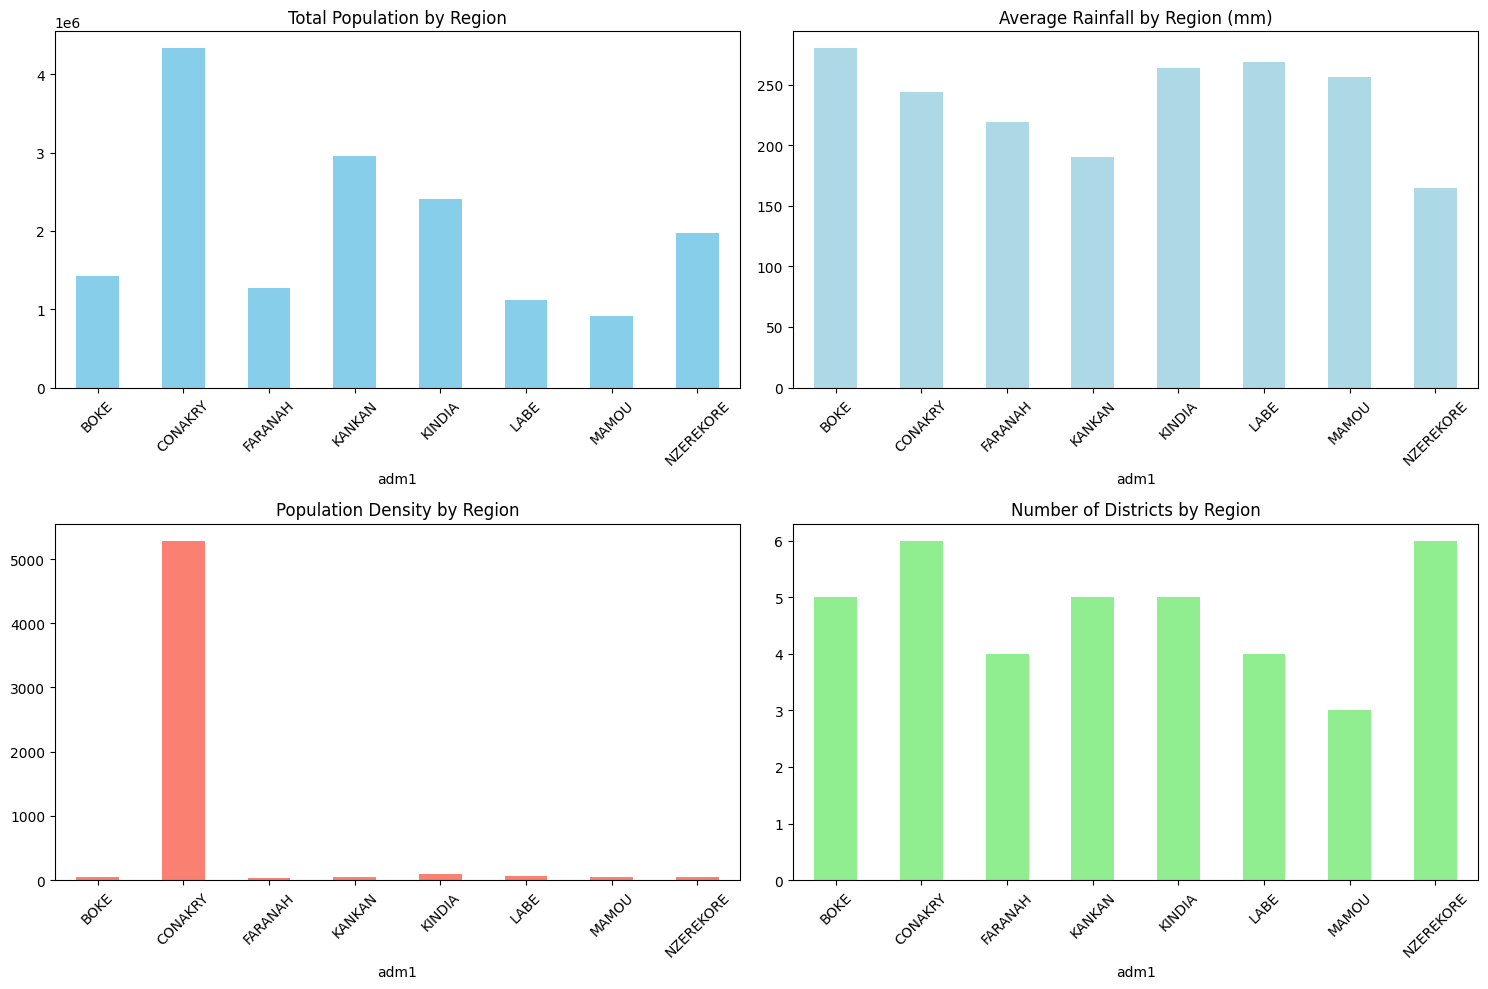

In [55]:
# Analyze disparities between regions (adm1 level)
regional_stats = gdf_final.groupby('adm1').agg({
    'pop': 'sum',
    'mean_rainfall_mm': 'mean',
    'area_sqkm': 'sum',
    'adm2': 'count'
}).rename(columns={'adm2': 'num_districts'})

regional_stats['pop_density'] = regional_stats['pop'] / regional_stats['area_sqkm']
regional_stats['rainfall_per_capita'] = (regional_stats['mean_rainfall_mm'] * regional_stats['area_sqkm']) / regional_stats['pop']

print("REGIONAL DISPARITIES ANALYSIS:")
print("=" * 50)
print(regional_stats.round(2))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Population distribution
regional_stats['pop'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Total Population by Region')
axes[0,0].tick_params(axis='x', rotation=45)

# Rainfall distribution
regional_stats['mean_rainfall_mm'].plot(kind='bar', ax=axes[0,1], color='lightblue')
axes[0,1].set_title('Average Rainfall by Region (mm)')
axes[0,1].tick_params(axis='x', rotation=45)

# Population density
regional_stats['pop_density'].plot(kind='bar', ax=axes[1,0], color='salmon')
axes[1,0].set_title('Population Density by Region')
axes[1,0].tick_params(axis='x', rotation=45)

# Number of districts
regional_stats['num_districts'].plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Number of Districts by Region')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [58]:
from esda.moran import Moran
from libpysal.weights import Queen

# Check for spatial autocorrelation in population and rainfall
def calculate_morans_i(gdf, column):
    """Calculate Moran's I for spatial autocorrelation"""
    try:
        # Create spatial weights matrix
        w = Queen.from_dataframe(gdf)
        w.transform = 'r'

        # Calculate Moran's I
        moran = Moran(gdf[column], w)
        return moran.I, moran.p_sim
    except:
        return np.nan, np.nan

# Calculate for both variables
pop_moran, pop_pval = calculate_morans_i(gdf_final, 'pop')
rainfall_moran, rainfall_pval = calculate_morans_i(gdf_final, 'mean_rainfall_mm')

print("SPATIAL AUTOCORRELATION ANALYSIS:")
print("=" * 40)
print(f"Population Moran's I: {pop_moran:.3f} (p-value: {pop_pval:.3f})")
print(f"Rainfall Moran's I: {rainfall_moran:.3f} (p-value: {rainfall_pval:.3f})")

# Interpret results
def interpret_moran(moran_i):
    if moran_i > 0:
        return "Clustered"
    elif moran_i < 0:
        return "Dispersed"
    else:
        return "Random"

print(f"\nPopulation distribution is: {interpret_moran(pop_moran)}")
print(f"Rainfall distribution is: {interpret_moran(rainfall_moran)}")

/tmp/ipython-input-804609713.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


SPATIAL AUTOCORRELATION ANALYSIS:
Population Moran's I: 0.056 (p-value: 0.221)
Rainfall Moran's I: nan (p-value: 0.001)

Population distribution is: Clustered
Rainfall distribution is: Random


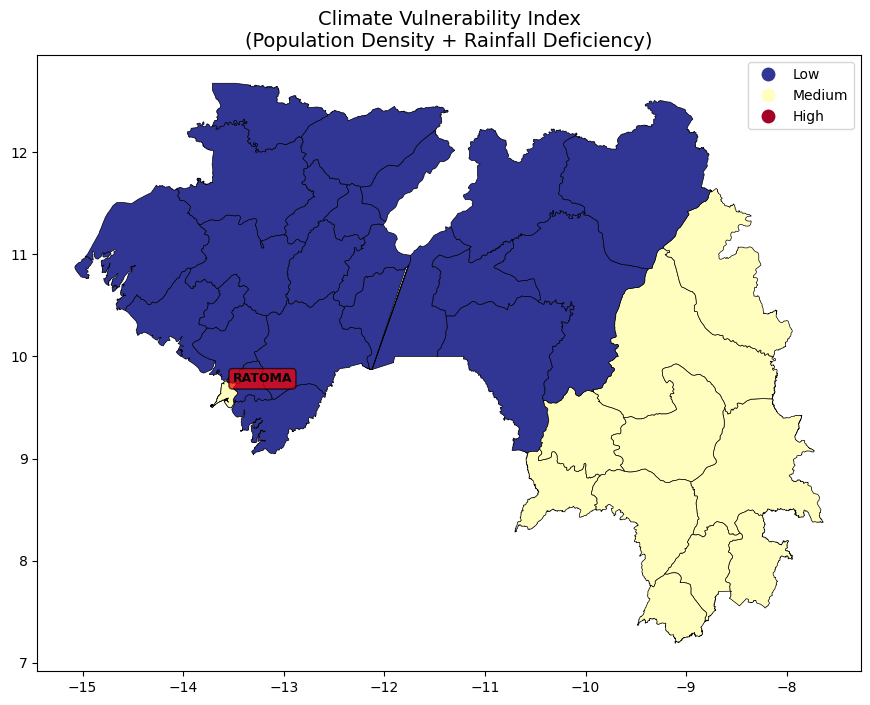

Vulnerability Distribution:
vulnerability_category
Low       22
Medium    12
High       1
Name: count, dtype: int64


In [59]:
# Create a composite vulnerability index
from sklearn.preprocessing import MinMaxScaler

def create_vulnerability_index(gdf):
    """Create a climate vulnerability index"""
    # Select relevant indicators
    indicators = ['pop_density', 'mean_rainfall_mm']

    # Normalize indicators (0-1)
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(
        scaler.fit_transform(gdf[indicators]),
        columns=[f'norm_{col}' for col in indicators]
    )

    # Higher population density = more vulnerable
    # Lower rainfall = more vulnerable (inverse)
    gdf['vulnerability_index'] = (
        normalized['norm_pop_density'] +
        (1 - normalized['norm_mean_rainfall_mm'])
    ) / 2

    # Classify vulnerability
    gdf['vulnerability_category'] = pd.cut(
        gdf['vulnerability_index'],
        bins=[0, 0.33, 0.66, 1],
        labels=['Low', 'Medium', 'High']
    )

    return gdf

gdf_vulnerability = create_vulnerability_index(gdf_final.copy())

# Plot vulnerability map
fig, ax = plt.subplots(figsize=(12, 8))
gdf_vulnerability.plot(
    column='vulnerability_category',
    categorical=True,
    legend=True,
    ax=ax,
    cmap='RdYlBu_r',
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Climate Vulnerability Index\n(Population Density + Rainfall Deficiency)', fontsize=14)

# Add labels for high vulnerability areas
high_vuln = gdf_vulnerability[gdf_vulnerability['vulnerability_category'] == 'High']
for idx, row in high_vuln.iterrows():
    ax.annotate(
        text=row['adm2'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7)
    )

plt.show()

print("Vulnerability Distribution:")
print(gdf_vulnerability['vulnerability_category'].value_counts())

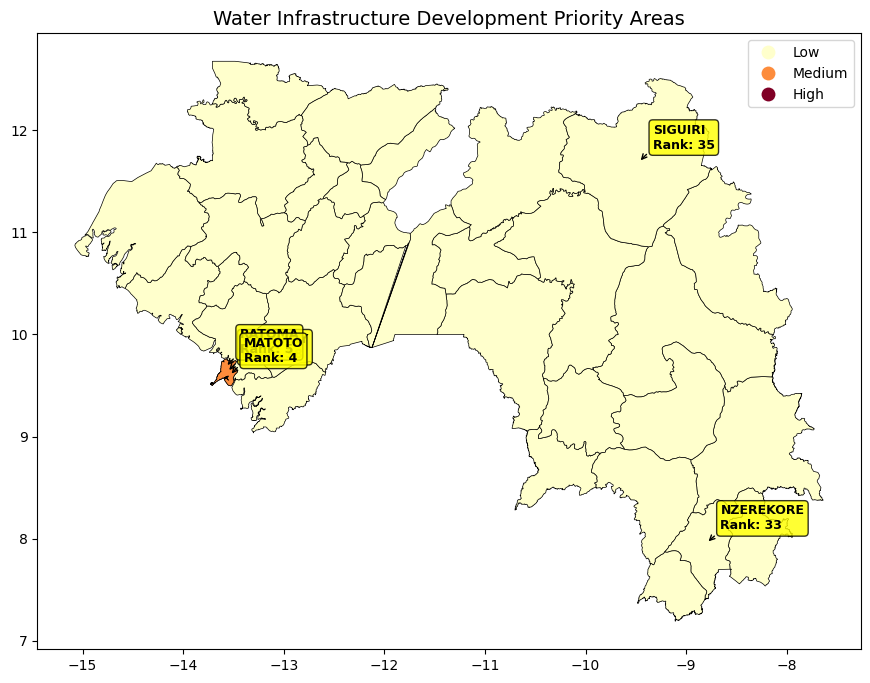

TOP 5 PRIORITY DISTRICTS FOR WATER INFRASTRUCTURE:
38. CONAKRY (Score: 0.597)
5. RATOMA (Score: 0.583)
4. MATOTO (Score: 0.431)
33. NZEREKORE (Score: 0.241)
35. SIGUIRI (Score: 0.227)


In [60]:
# Identify priority areas for water infrastructure
def identify_infrastructure_priority(gdf):
    """Identify priority areas for water infrastructure development"""

    # Criteria for prioritization
    gdf['priority_score'] = (
        (gdf['pop_density'] / gdf['pop_density'].max()) * 0.4 +  # Population density weight
        ((1 - gdf['mean_rainfall_mm'] / gdf['mean_rainfall_mm'].max())) * 0.4 +  # Rainfall deficiency weight
        (gdf['pop'] / gdf['pop'].max()) * 0.2  # Total population weight
    )

    # Classify priority levels
    gdf['priority_level'] = pd.cut(
        gdf['priority_score'],
        bins=[0, 0.3, 0.6, 1],
        labels=['Low', 'Medium', 'High'],
        right=False
    )

    return gdf

gdf_priority = identify_infrastructure_priority(gdf_final.copy())

# Create priority map
fig, ax = plt.subplots(figsize=(12, 8))
gdf_priority.plot(
    column='priority_level',
    categorical=True,
    legend=True,
    ax=ax,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Water Infrastructure Development Priority Areas', fontsize=14)

# Highlight top 5 priority districts
top_priority = gdf_priority.nlargest(5, 'priority_score')
for idx, row in top_priority.iterrows():
    ax.annotate(
        text=f"{row['adm2']}\nRank: {idx+1}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2")
    )

plt.show()

print("TOP 5 PRIORITY DISTRICTS FOR WATER INFRASTRUCTURE:")
print("=" * 50)
for idx, row in top_priority.iterrows():
    print(f"{idx+1}. {row['adm2']} (Score: {row['priority_score']:.3f})")

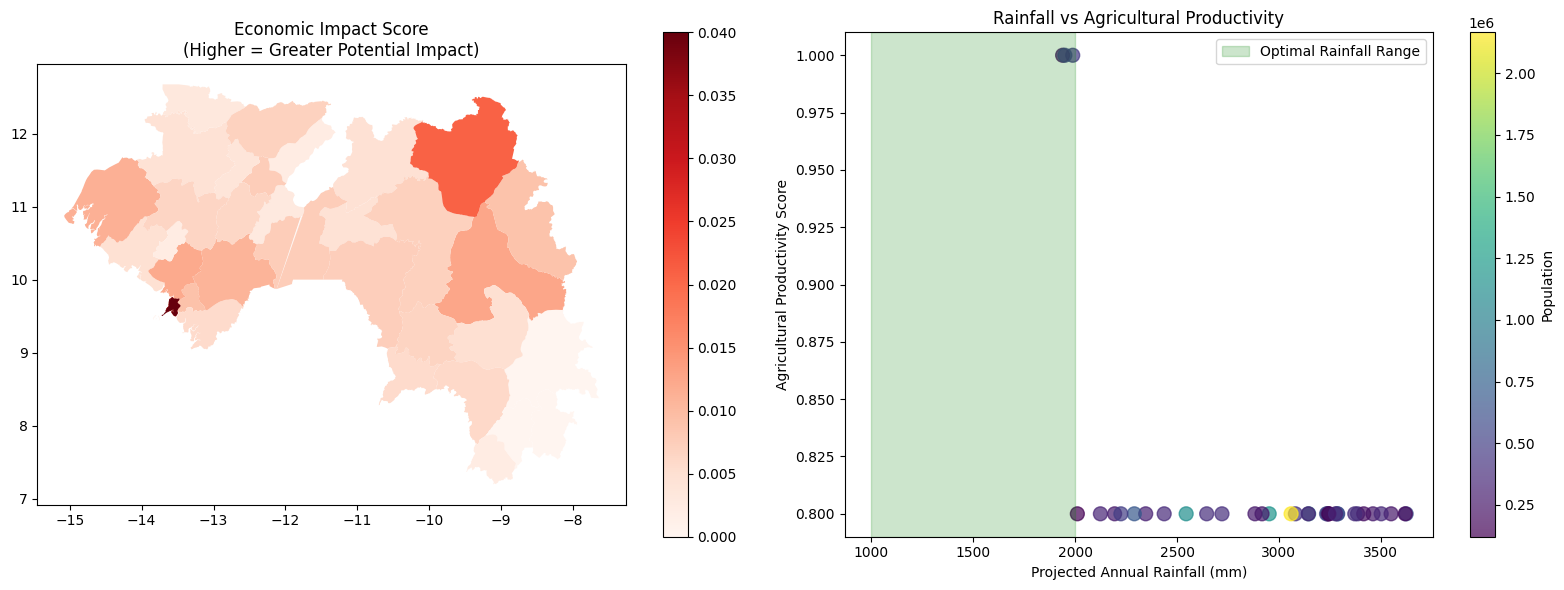

In [62]:
# Assess potential economic impacts
def economic_impact_assessment(gdf):
    """Assess potential economic impacts of rainfall patterns"""

    # Simplified economic model
    # Assume agriculture contributes 20% to local economy
    agriculture_contribution = 0.20

    # Rainfall impact on agriculture (optimal range: 1000-2000mm annually)
    gdf['agri_productivity'] = np.where(
        (gdf['projected_annual_rainfall'] >= 1000) & (gdf['projected_annual_rainfall'] <= 2000),
        1.0,  # Optimal
        np.where(gdf['projected_annual_rainfall'] < 1000, 0.6, 0.8)  # Suboptimal
    )

    # Economic impact score
    gdf['economic_impact_score'] = (
        agriculture_contribution * (1 - gdf['agri_productivity']) *
        (gdf['pop'] / gdf['pop'].max())
    )

    return gdf

gdf_economic = economic_impact_assessment(gdf_projected.copy())

# Economic impact visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Economic impact map
gdf_economic.plot(column='economic_impact_score', ax=ax1, legend=True, cmap='Reds')
ax1.set_title('Economic Impact Score\n(Higher = Greater Potential Impact)')

# Agriculture productivity vs rainfall
scatter = ax2.scatter(gdf_economic['projected_annual_rainfall'],
                     gdf_economic['agri_productivity'],
                     c=gdf_economic['pop'], s=100, alpha=0.7, cmap='viridis')
ax2.axvspan(1000, 2000, alpha=0.2, color='green', label='Optimal Rainfall Range')
ax2.set_xlabel('Projected Annual Rainfall (mm)')
ax2.set_ylabel('Agricultural Productivity Score')
ax2.set_title('Rainfall vs Agricultural Productivity')
ax2.legend()
plt.colorbar(scatter, ax=ax2, label='Population')

plt.tight_layout()
plt.show()

In [63]:
# Create a comprehensive summary dashboard
print("COMPREHENSIVE ANALYTICAL SUMMARY")
print("=" * 60)

# Key findings summary
summary_data = {
    'Metric': [
        'Total Population',
        'Average Rainfall (Sept 2025)',
        'Highest Population Density',
        'Lowest Rainfall Area',
        'Water Stress Risk Areas',
        'High Vulnerability Districts',
        'Top Infrastructure Priority'
    ],
    'Value': [
        f"{gdf_final['pop'].sum():,}",
        f"{gdf_final['mean_rainfall_mm'].mean():.1f} mm",
        f"{gdf_final.loc[gdf_final['pop_density'].idxmax(), 'adm2']}",
        f"{gdf_final.loc[gdf_final['mean_rainfall_mm'].idxmin(), 'adm2']}",
        f"{(gdf_vulnerability['vulnerability_category'] == 'High').sum()} districts",
        f"{(gdf_vulnerability['water_stress_risk'] == 'High Risk').sum()} districts",
        f"{gdf_priority.nlargest(1, 'priority_score')['adm2'].iloc[0]}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 60)
print("RECOMMENDATIONS:")
print("1. Focus water infrastructure in high priority districts")
print("2. Implement water conservation in high population density areas")
print("3. Develop climate adaptation strategies for vulnerable regions")
print("4. Monitor rainfall patterns in economically critical areas")

COMPREHENSIVE ANALYTICAL SUMMARY
                      Metric        Value
            Total Population   16,400,509
Average Rainfall (Sept 2025)     231.6 mm
  Highest Population Density       RATOMA
        Lowest Rainfall Area         LOLA
     Water Stress Risk Areas  1 districts
High Vulnerability Districts 35 districts
 Top Infrastructure Priority      CONAKRY

RECOMMENDATIONS:
1. Focus water infrastructure in high priority districts
2. Implement water conservation in high population density areas
3. Develop climate adaptation strategies for vulnerable regions
4. Monitor rainfall patterns in economically critical areas
